In [1]:
%load_ext autoreload
%autoreload 2

In [157]:
import numpy as np
import skimage
import os
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from defects_dlmbl.unetmodule import UNetModuleWithMetricAuxiliary, UNetModule
from defects_dlmbl.datasets import CREMIDataset
from defects_dlmbl.segment_affinities import mutex_watershed

In [3]:
os.chdir('/home/funkl/defects_DLMBL')

# load from checkpoints

In [4]:
f = 'experiments/lightning_logs/version_48/checkpoints/cremi_auxiliary-epoch636-val_loss0.27.ckpt'

In [299]:
f_naive = 'experiments/lightning_logs/version_51/checkpoints/cremi_auxiliary-epoch412-val_loss0.89.ckpt'

In [5]:
trained_model = UNetModuleWithMetricAuxiliary.load_from_checkpoint(f)

In [300]:
trained_naive_model = UNetModule.load_from_checkpoint(f_naive)

In [302]:
trained_naive_model.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('unet',
               UNet(
                 (l_conv): ModuleList(
                   (0): ConvPass(
                     (conv_pass): Sequential(
                       (0): Conv2d(1, 18, kernel_size=(3, 3), stride=(1, 1))
                       (1): ReLU()
                       (2): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1))
                       (3): ReLU()
                     )
                   )
                   (1): ConvPass(
                     (conv_pass): Sequential(
                       (0): Conv2d(18, 54, kernel_size=(3, 3), stride=(1, 1))
                       (1): ReLU()
                       

# load full image

In [6]:
dataset = CREMIDataset('data/training_data*',augment_and_crop=False,pad=5) 

In [7]:
len(dataset)

372

In [8]:
raw,gt_affinities,gt_seg = dataset[-1]

In [9]:
raw.shape,gt_affinities.shape,gt_seg.shape

(torch.Size([1260, 1260]),
 torch.Size([4, 1250, 1250]),
 torch.Size([1, 1250, 1250]))

# predict

In [10]:
_ = trained_model.eval()

In [159]:
with torch.no_grad():
    prediction = trained_model(raw[None,None])
    prediction_naive = trained_naive_model(raw[None,None])

In [160]:
prediction.shape,prediction_naive.shape

(torch.Size([1, 20, 1172, 1172]), torch.Size([1, 4, 1172, 1172]))

In [13]:
affinity_channels = 4

In [14]:
aff_logits = prediction[0,:affinity_channels]
metric_pred = prediction[0,affinity_channels:]

In [161]:
aff_logits_naive = prediction_naive[0]

In [162]:
aff_pred = torch.sigmoid(aff_logits)
aff_pred_naive = torch.sigmoid(aff_logits_naive)

In [163]:
aff_pred.shape,metric_pred.shape,aff_pred_naive.shape

(torch.Size([4, 1172, 1172]),
 torch.Size([16, 1172, 1172]),
 torch.Size([4, 1172, 1172]))

In [177]:
1172/2

586.0

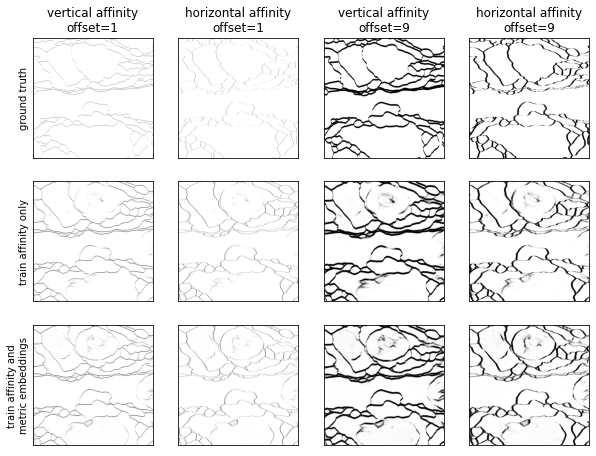

In [182]:
fig,axes = plt.subplots(3,4,figsize=(10,7.5))

for n,(ax_col,pred,gt,pred_n) in enumerate(zip(axes.T,aff_pred,gt_affinities,aff_pred_naive)):
    ax_col[2].imshow(-(pred-1)[550:,550:],cmap='gray')
    ax_col[0].imshow(-(gt-1)[550:,550:],cmap='gray')
    ax_col[1].imshow(-(pred_n-1)[550:,550:],cmap='gray')


axes[0,0].set_ylabel('ground truth')
axes[1,0].set_ylabel('train affinity only')
axes[2,0].set_ylabel('train affinity and\nmetric embeddings')

axes[0,0].set_title('vertical affinity\noffset=1')
axes[0,1].set_title('horizontal affinity\noffset=1')
axes[0,2].set_title('vertical affinity\noffset=9')
axes[0,3].set_title('horizontal affinity\noffset=9')

_ = [ax.set_yticks([]) for ax in axes.flatten()]
_ = [ax.set_xticks([]) for ax in axes.flatten()]

plt.savefig('experiments/dataset_C_example_affinities.png',dpi=300,bbox_inches='tight',transparent=True)

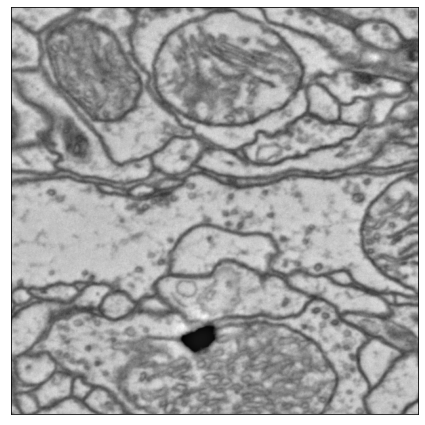

In [185]:
fig,ax = plt.subplots(1,1,figsize=(7.5,7.5))

# for n,(ax_col,pred,gt,pred_n) in enumerate(zip(axes.T,aff_pred,gt_affinities,aff_pred_naive)):
ax.imshow(raw_sliced[550:,550:],cmap='gray')


# axes[0,0].set_ylabel('ground truth')
# axes[1,0].set_ylabel('train affinity only')
# axes[2,0].set_ylabel('train affinity and\nmetric embeddings')

# axes[0,0].set_title('vertical affinity\noffset=1')
# axes[0,1].set_title('horizontal affinity\noffset=1')
# axes[0,2].set_title('vertical affinity\noffset=9')
# axes[0,3].set_title('horizontal affinity\noffset=9')

ax.set_yticks([])
_=ax.set_xticks([])
# _ = [ax.set_yticks([]) for ax in axes.flatten()]
# _ = [ax.set_xticks([]) for ax in axes.flatten()]

plt.savefig('experiments/dataset_C_example_crop.png',dpi=300,bbox_inches='tight',transparent=True)

In [20]:
trained_model.offsets

[[-1, 0], [0, -1], [-9, 0], [0, -9]]

In [21]:
aff_pred.shape

torch.Size([4, 1172, 1172])

In [22]:
seg_pred = mutex_watershed(aff_pred.unsqueeze(0).numpy(),trained_model.offsets)

In [189]:
seg_pred_naive = mutex_watershed(aff_pred_naive.unsqueeze(0).numpy(),trained_naive_model.offsets)

In [23]:
seg_pred.shape

(1, 1, 1172, 1172)

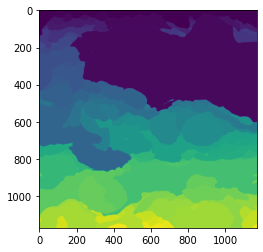

In [24]:
plt.imshow(seg_pred[0,0])

In [83]:
metric_pred_norm = metric_pred.numpy().copy()
metric_pred_norm -= metric_pred_norm.min(axis=(-1,-2),keepdims=True)
metric_pred_norm /= metric_pred_norm.max(axis=(-1,-2),keepdims=True)

In [85]:
metric_pred_pca = trained_model.image_metric_pca(metric_pred_norm,return_dimensions=None)

In [86]:
metric_pred_pca.shape

(16, 1172, 1172)

In [147]:
os.getcwd()

'/home/funkl/defects_DLMBL'

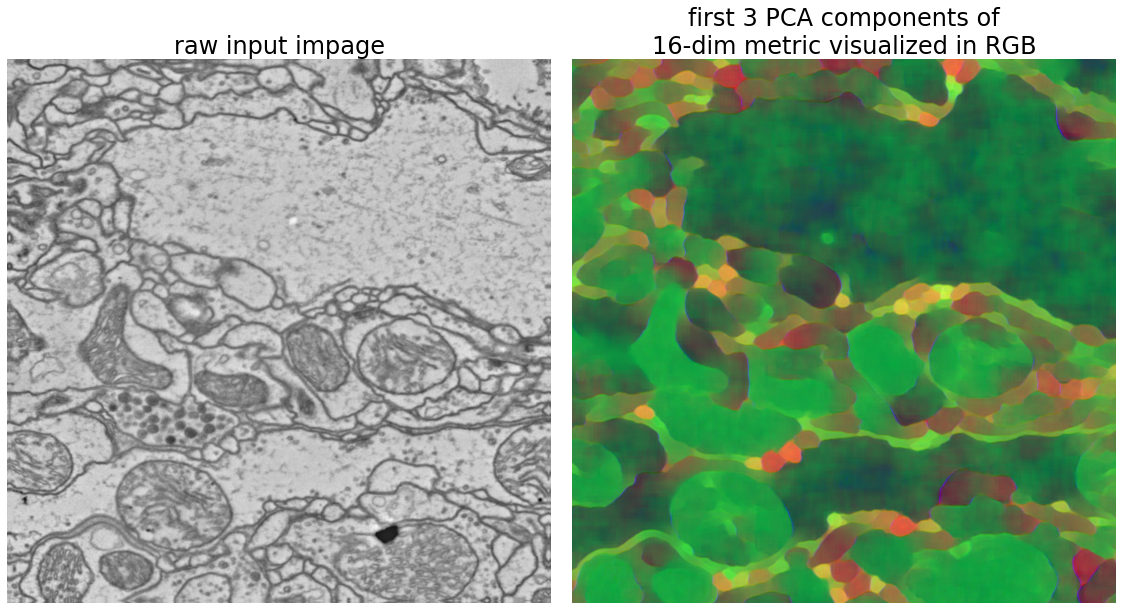

In [188]:
fig,axes = plt.subplots(1,2,figsize=(20,10),gridspec_kw={'wspace':0.025,'hspace':0.1})

axes[0].imshow(raw,cmap='gray')
axes[0].set_title('raw input impage',fontsize=24)
axes[1].imshow(metric_pred_pca[:3].transpose((1,2,0)))
axes[1].set_title('first 3 PCA components of\n16-dim metric visualized in RGB',fontsize=24)

_=[ax.axis('off') for ax in axes.flatten()]
plt.savefig('experiments/dataset_C_example_metric_projection.png',dpi=300,bbox_inches='tight',transparent=True)

In [192]:
seg_pred_naive.shape

(1, 1, 1172, 1172)

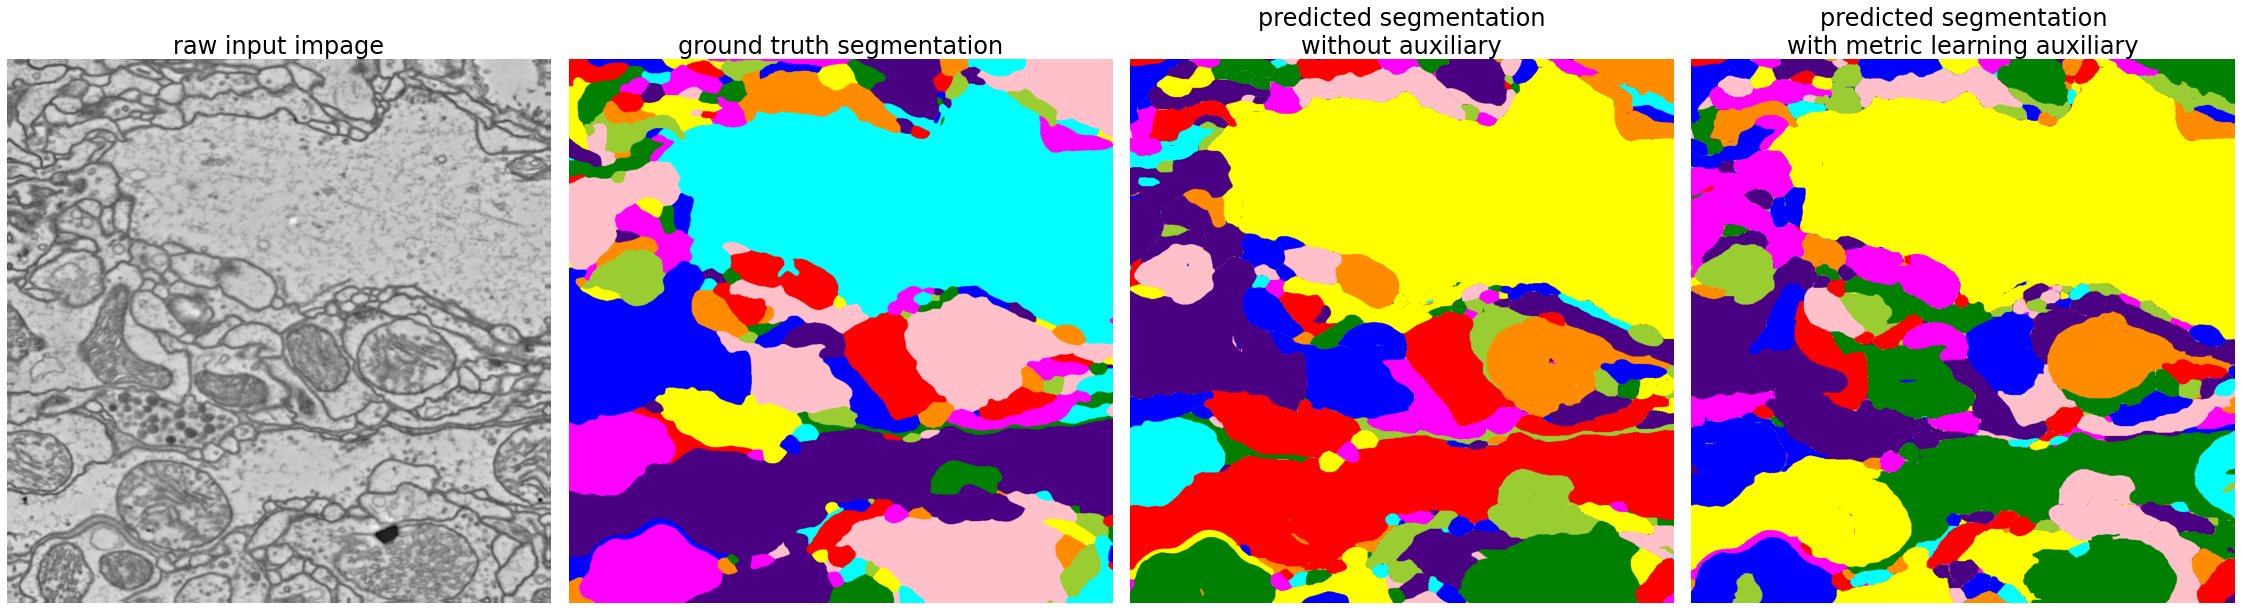

In [196]:
fig,axes = plt.subplots(1,4,figsize=(40,10),gridspec_kw={'wspace':0.025,'hspace':0.1})

axes[0].imshow(raw,cmap='gray')
axes[0].set_title('raw input impage',fontsize=24)
axes[3].imshow(skimage.color.label2rgb(seg_pred[0,0],bg_label=0))
axes[3].set_title('predicted segmentation\nwith metric learning auxiliary',fontsize=24)
axes[1].imshow(skimage.color.label2rgb(gt_seg.numpy()[0],bg_label=0))
axes[1].set_title('ground truth segmentation',fontsize=24)
axes[2].imshow(skimage.color.label2rgb(seg_pred_naive[0,0],bg_label=0))
axes[2].set_title('predicted segmentation\nwithout auxiliary',fontsize=24)

_=[ax.axis('off') for ax in axes.flatten()]
plt.savefig('experiments/dataset_C_example_predictions.png',dpi=300,bbox_inches='tight',transparent=True)

In [28]:
raw_sliced = raw[44:-44,44:-44].numpy()

In [30]:
props = skimage.measure.regionprops_table(
    seg_pred[0,0],
    intensity_image=raw_sliced,
    properties=('label','area','eccentricity',
                'extent','feret_diameter_max',
                'orientation','solidity',
                'mean_intensity','min_intensity',
                'max_intensity'
               ))

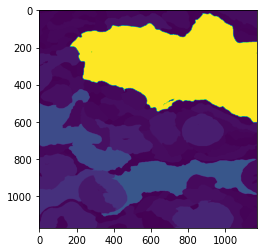

In [31]:
plt.imshow(props['area'][seg_pred[0,0]-1])

In [33]:
from scipy.ndimage import distance_transform_edt

In [34]:
boundaries_pred = skimage.segmentation.find_boundaries(seg_pred[0,0])

In [35]:
dt_pred = distance_transform_edt(1-boundaries_pred)

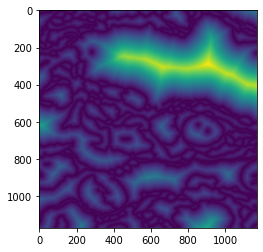

In [36]:
plt.imshow(dt_pred)

In [37]:
mean_embeddings = np.array([skimage.measure.regionprops_table(
    seg_pred[0,0],
    intensity_image=metric_pred[n].numpy(),
    properties=('label','mean_intensity'))['mean_intensity'][seg_pred[0,0]-1]
          for n in range(16)
         ])

In [40]:
mean_embeddings.shape

(16, 1172, 1172)

In [88]:
norm_mean_embeddings = mean_embeddings.copy()
norm_mean_embeddings -= norm_mean_embeddings.min(axis=(-1,-2),keepdims=True)
norm_mean_embeddings /= norm_mean_embeddings.max(axis=(-1,-2),keepdims=True)

In [47]:
norm_mean_embeddings.min(axis=(-1,-2))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [48]:
norm_mean_embeddings.max(axis=(-1,-2))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

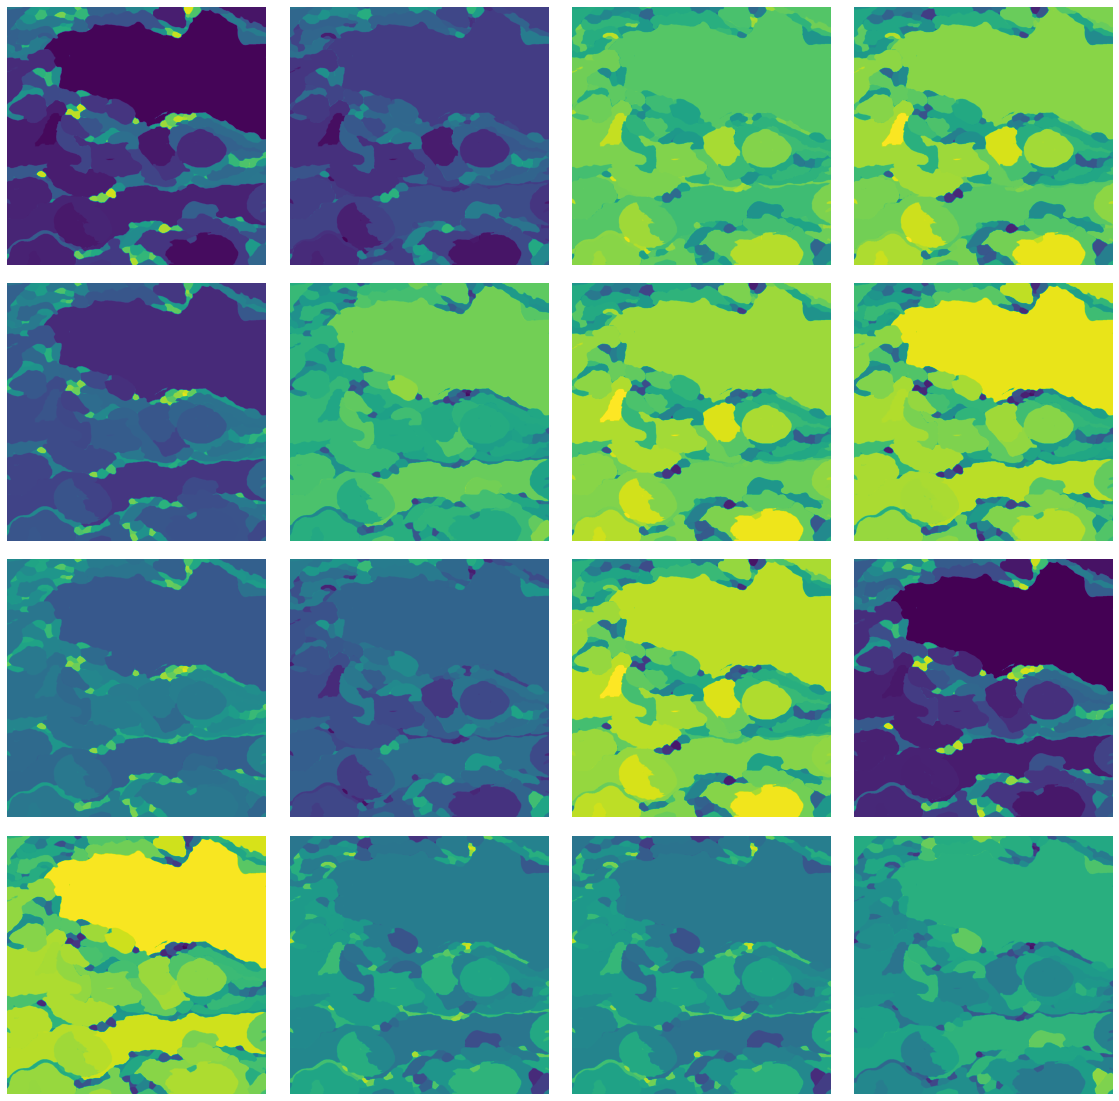

In [42]:
fig,axes = plt.subplots(4,4,figsize=(20,20),gridspec_kw={'wspace':0.05,'hspace':0.07})

for ax,emb in zip(axes.flatten(),norm_mean_embeddings):
    ax.imshow(emb)
    ax.axis('off')

In [121]:
def pca_unique_embeddings(embeddings_image,labels,in_dim=16):
    u,i= np.unique(embeddings_image.reshape(in_dim,-1),axis=1,return_index=True)
    matching_labels = np.array([(labels[np.unravel_index(i_,(labels.shape))]) for i_ in i])-1
    
    pca = PCA()

    u_norm = u.copy()
    u_norm -= u_norm.min(axis=-1,keepdims=True)
    u_norm /= u_norm.max(axis=-1,keepdims=True)

    u_pca = pca.fit_transform(u_norm.T)
    
    out = np.zeros_like(embeddings_image)
    
    for ml,emb in zip(matching_labels,u_pca):
        for dim in range(in_dim):
            out[dim,labels==ml] = emb[dim]
        
    return out 

In [337]:
u,i= np.unique(mean_embeddings.reshape(16,-1),axis=1,return_index=True)
matching_labels = np.array([(seg_pred[0,0,np.unravel_index(i_,(seg_pred[0,0].shape))]) for i_ in i])-1

pca = PCA()

u_norm = u.copy()
u_norm -= u_norm.min(axis=-1,keepdims=True)
u_norm /= u_norm.max(axis=-1,keepdims=True)

u_pca = pca.fit_transform(u_norm.T)

In [338]:
u_pca.shape

(4966, 16)

(0.2, 16.2)

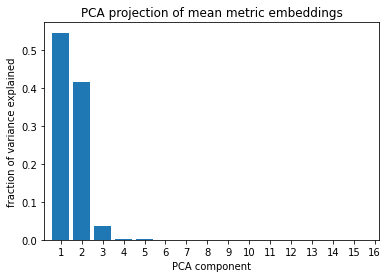

In [341]:
fig,ax = plt.subplots(1,1)

ax.bar(list(range(1,17)),pca.explained_variance_ratio_)
ax.set_ylabel('fraction of variance explained')
ax.set_xlabel('PCA component')
ax.set_title('PCA projection of mean metric embeddings')
ax.set_xticks(list(range(17)))
ax.set_xlim([0.2,16.2])
# ax.set_yscale('log')
# plt.savefig('experiments/PCA_variance_explained.png',dpi=300,bbox_inches='tight',transparent=True)

In [339]:
u_pca

array([[-1.01415422e+00, -5.65879029e-01,  7.97310865e-02, ...,
        -1.69509087e-08, -1.60421636e-08,  2.65333617e-08],
       [-1.14705636e+00, -3.98464277e-01, -1.08018348e-01, ...,
         3.17874829e-09, -3.32159509e-08,  1.06494556e-08],
       [-9.70784950e-01, -5.15380149e-01,  1.69726920e-01, ...,
        -2.58716006e-08,  9.99523903e-09, -7.78697904e-09],
       ...,
       [ 9.32710178e-01,  1.02477416e+00, -6.96103049e-02, ...,
        -3.11545640e-09,  1.38291003e-08, -8.87795320e-09],
       [ 9.02365282e-01,  1.28578975e+00,  1.68430012e-01, ...,
        -1.05575069e-08, -2.33122856e-08,  5.54384652e-08],
       [ 9.59127445e-01,  1.30908311e+00,  1.28116457e-01, ...,
        -1.79786460e-09,  8.51835381e-09, -9.95647325e-09]])

In [135]:
u_pca.min(axis=0)

array([-1.34953012e+00, -1.17988409e+00, -3.56131274e-01, -8.93251295e-02,
       -7.18017589e-02, -2.82235287e-02, -5.67757518e-03, -1.67016638e-03,
       -2.49371673e-04, -2.27192497e-04, -9.83520580e-06, -1.31875104e-07,
       -1.33678979e-07, -1.09317937e-07, -8.13433889e-08, -7.57645928e-08])

In [136]:
u_pca.max(axis=0)

array([1.52761348e+00, 1.32033261e+00, 4.42098957e-01, 1.11368636e-01,
       8.86192866e-02, 2.88999477e-02, 7.39540717e-03, 5.70762499e-03,
       5.08481898e-04, 3.51046011e-04, 6.97645895e-04, 1.34806176e-07,
       1.96903686e-07, 1.28735460e-07, 1.06407913e-07, 9.24433842e-08])

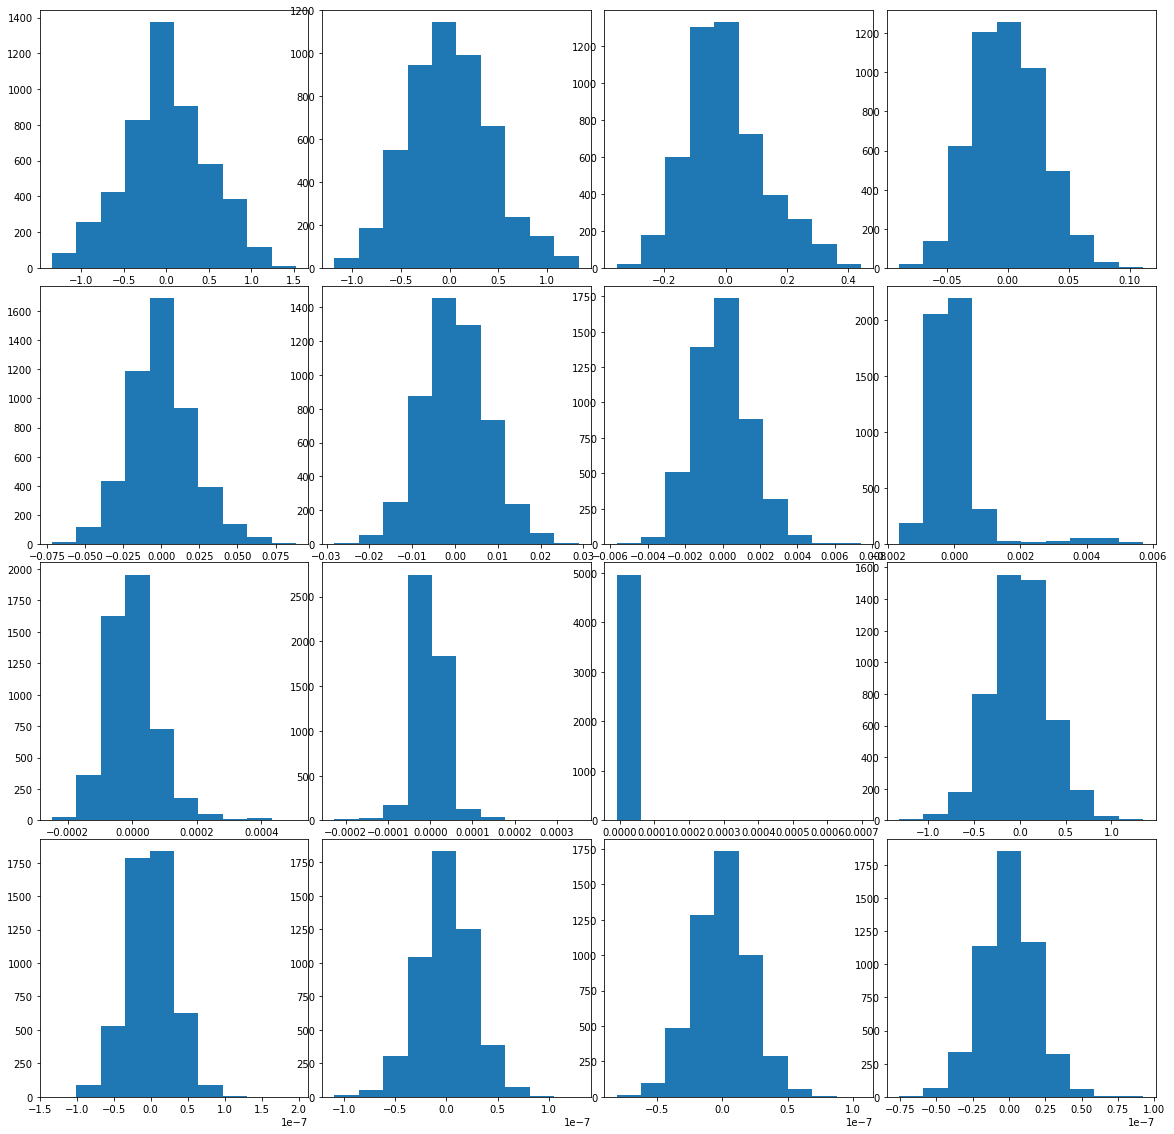

In [130]:
fig,axes = plt.subplots(4,4,figsize=(20,20),gridspec_kw={'wspace':0.05,'hspace':0.07})

for ax,u_pca_ in zip(axes.flatten(),u_pca.T):
    ax.hist(u_pca_)

In [142]:
# slow
# check = pca_unique_embeddings(mean_embeddings,seg_pred[0,0])

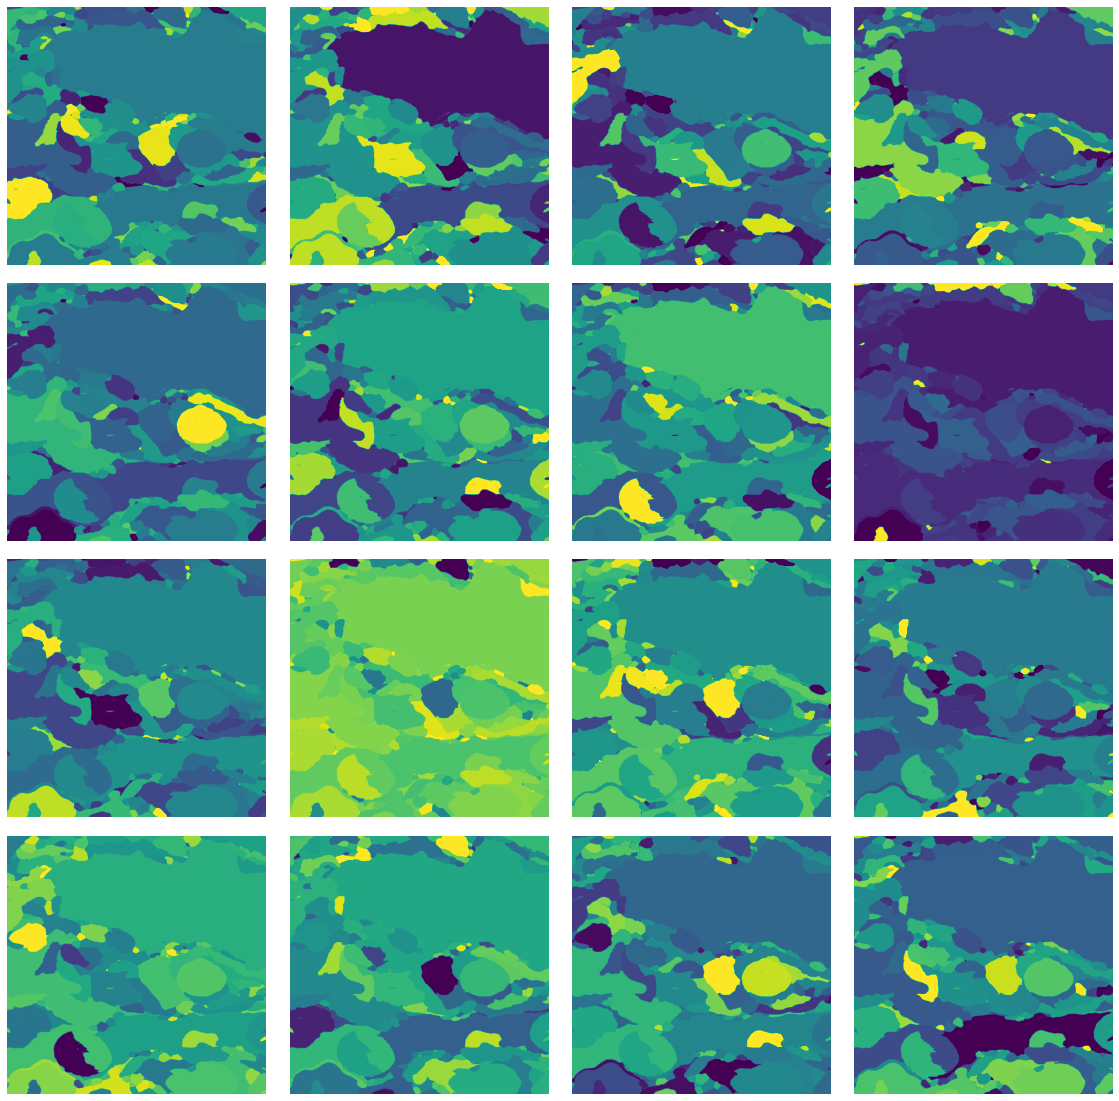

In [141]:
fig,axes = plt.subplots(4,4,figsize=(20,20),gridspec_kw={'wspace':0.05,'hspace':0.07})

for ax,emb in zip(axes.flatten(),check):
    ax.imshow(emb,vmin=np.quantile(emb,0.01),vmax=np.quantile(emb,0.99))
    ax.axis('off')

In [96]:
u_pca.shape

(218, 16)

In [92]:
u,inv= np.unique(mean_embeddings.reshape(16,-1),axis=1,return_inverse=True)

In [93]:
u.shape,inv.shape

((16, 4966), (1373584,))

In [95]:
u[inv]

MemoryError: Unable to allocate 50.8 GiB for an array with shape (1373584, 4966) and data type float64

In [91]:
u.shape

(16, 218)

In [89]:
u_pca.shape

(218, 16)

In [ ]:
metric_pred_pca = trained_model.image_metric_pca(norm_mean_embeddings,return_dimensions=None)

# plot against PCA, filter out single pixel segmentation

In [236]:
area_images = props['area'][seg_pred[0,0]-1]
single_pixel_mask = area_images>30

In [237]:
1172**2-single_pixel_mask.sum()

10390

In [238]:
u,i= np.unique(mean_embeddings[...,single_pixel_mask],axis=1,return_index=True)

In [239]:
i.shape

(218,)

In [240]:
len(np.unique(i))

218

In [241]:
s = int(seg_pred.shape[-1]/2-15)

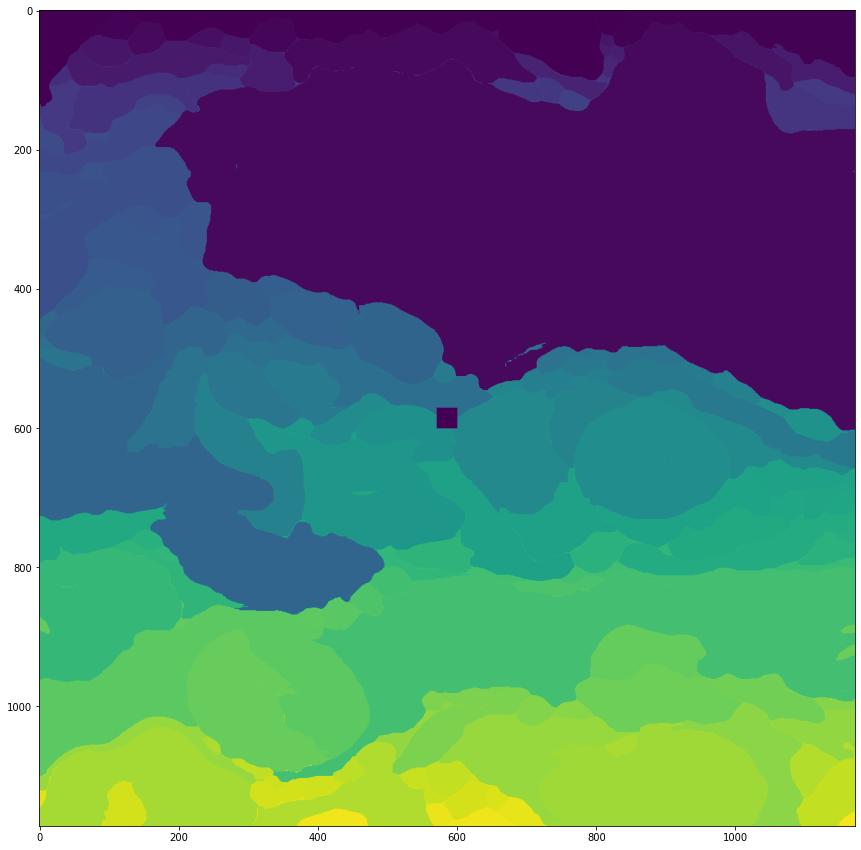

In [242]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
check = seg_pred[0,0].copy()
check[s:-s,s:-s]=0
ax.imshow(
#     skimage.color.label2rgb(check,bg_label=0)
    check
)

In [243]:
label_masked=seg_pred[0,0,single_pixel_mask]

In [244]:
matching_labels = np.array([(label_masked[i_]
                            ) for i_ in i])

In [245]:
len(np.unique(matching_labels))

218

In [246]:
pca = PCA()

In [247]:
u_norm = u.copy()

In [248]:
u_norm -= u_norm.min(axis=-1,keepdims=True)
u_norm /= u_norm.max(axis=-1,keepdims=True)

In [249]:
u_pca = pca.fit_transform(u_norm.T)

In [250]:
np.unravel_index(996932,area_images.shape)

(850, 732)

In [251]:
ax.get_xlim()

(-0.5, 1171.5)

(0.2, 16.2)

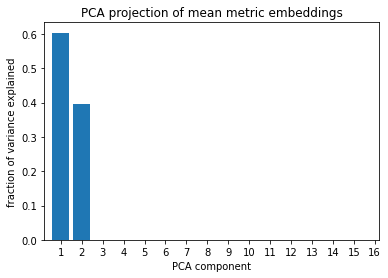

In [336]:
fig,ax = plt.subplots(1,1)

ax.bar(list(range(1,17)),pca.explained_variance_ratio_)
ax.set_ylabel('fraction of variance explained')
ax.set_xlabel('PCA component')
ax.set_title('PCA projection of mean metric embeddings')
ax.set_xticks(list(range(17)))
ax.set_xlim([0.2,16.2])
# ax.set_yscale('log')
# plt.savefig('experiments/PCA_variance_explained.png',dpi=300,bbox_inches='tight',transparent=True)

In [253]:
single_pixel_labels = [props['label'][n] for n,area in enumerate(props['area']) if area==1]

In [291]:
def plot_mean_pca_emb_vs_feature(feature):
    
    fig,axes = plt.subplots(1,4,figsize=(20,5),sharey=True,gridspec_kw={'hspace':0.25,'wspace':0.05})
    
    features = np.array([props[feature][l] for l in matching_labels-1])

    for n,(ax,emb) in enumerate(zip(axes.flatten(),u_pca.T[:4])):
        ax.scatter(y=features,x=emb)
        ax.set_title(f'pca component {n+1} of metric embeddings')
        if feature in ['area','feret_diameter_max']:
            ax.set_yscale('log')
#         ax.set_yticklabels([])
        ax.set_xlabel(f'mean instance embedding component')
#         ax.set_ylabel(feature)
            
        
#     plt.setp(axes[:, 0], ylabel=f'instance {feature}')
    axes[0].set_ylabel(f'instance {feature}')
    return axes

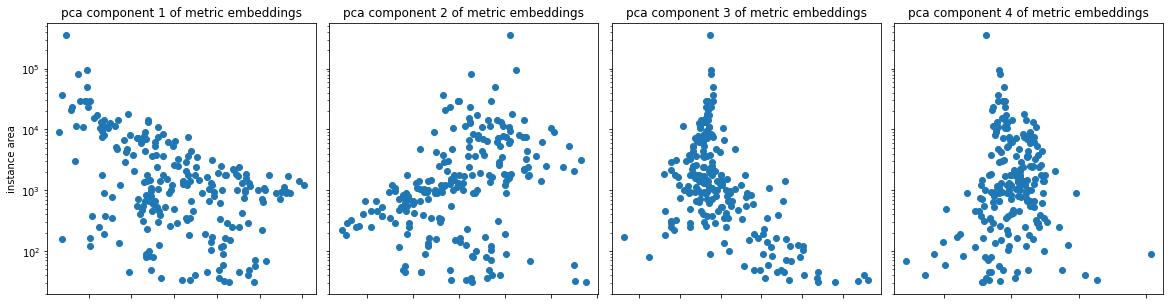

In [295]:
axes = plot_mean_pca_emb_vs_feature('area')
_= [ax.set_xticklabels([]) for ax in axes.flatten()]
_= [ax.set_xlabel('') for ax in axes.flatten()]
plt.savefig('experiments/area_vs_metrics.png',dpi=300,bbox_inches='tight',transparent=True)

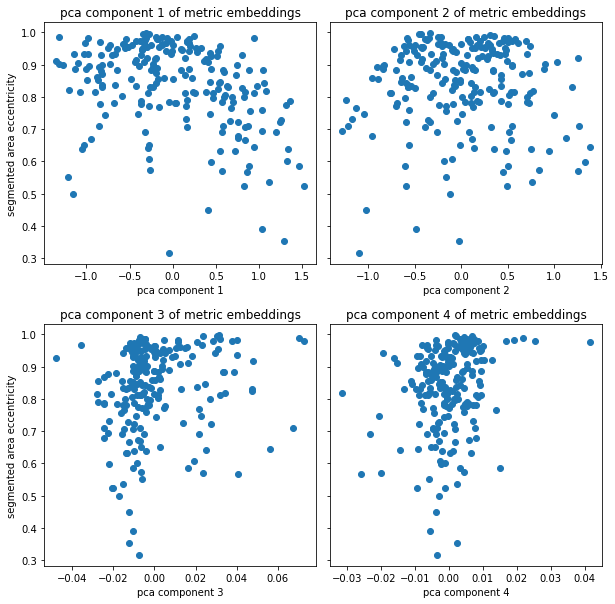

In [256]:
_ = plot_mean_pca_emb_vs_feature('eccentricity')

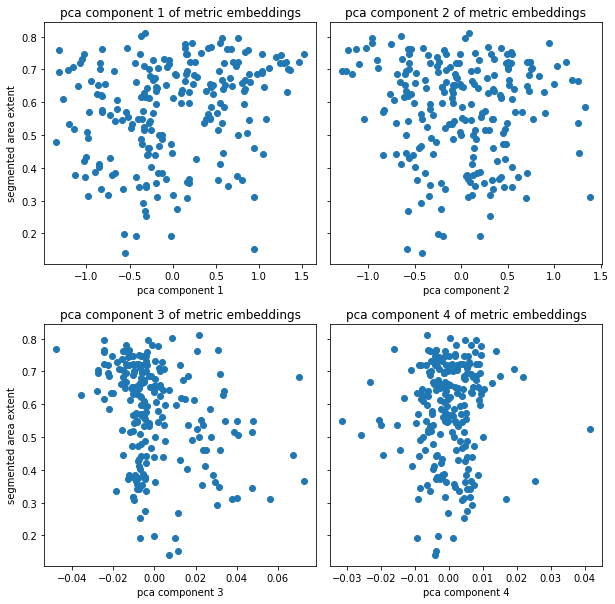

In [257]:
_ = plot_mean_pca_emb_vs_feature('extent')

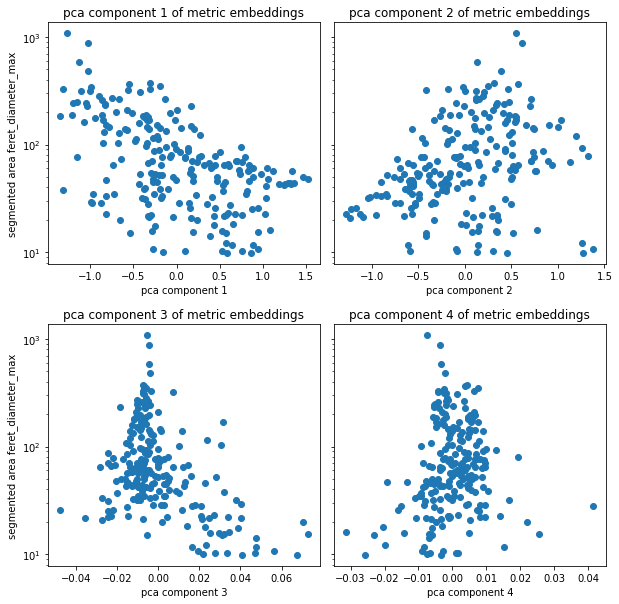

In [258]:
_ = plot_mean_pca_emb_vs_feature('feret_diameter_max')

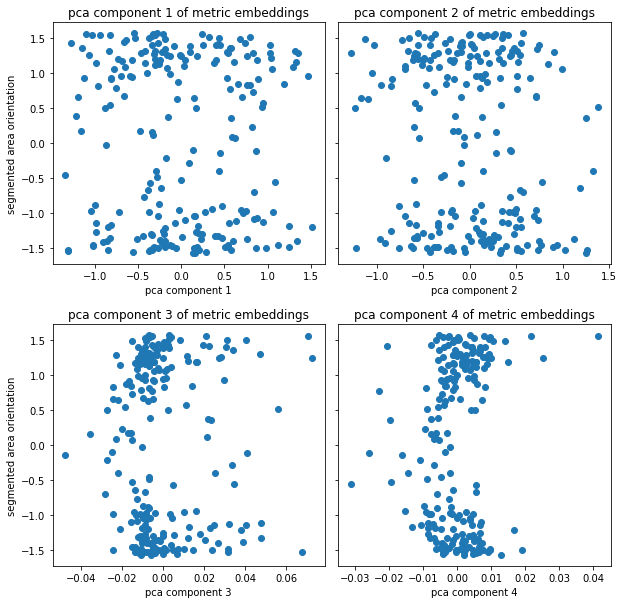

In [259]:
_ = plot_mean_pca_emb_vs_feature('orientation')

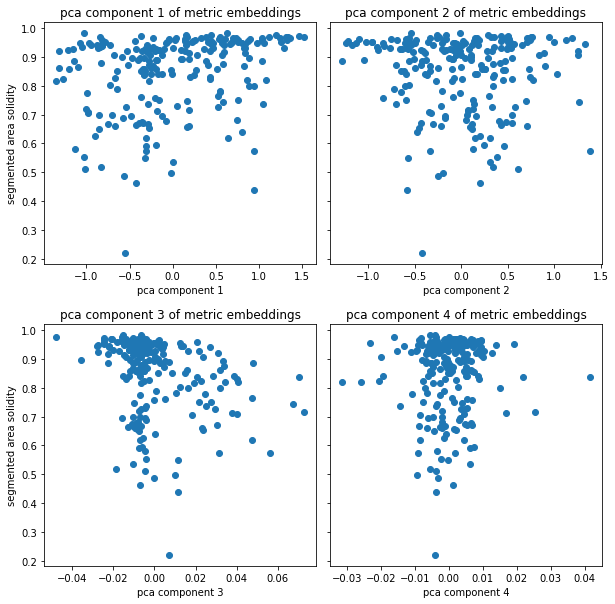

In [260]:
_ = plot_mean_pca_emb_vs_feature('solidity')

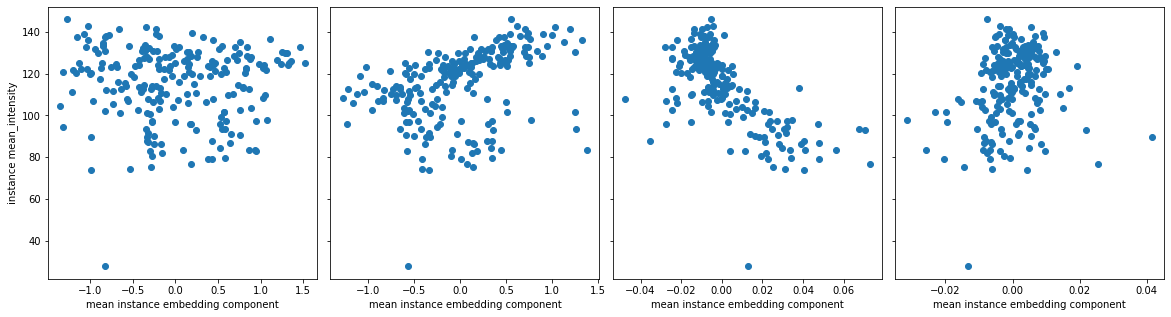

In [297]:
axes = plot_mean_pca_emb_vs_feature('mean_intensity')
_= [ax.set_title('') for ax in axes.flatten()]
plt.savefig('experiments/mean_vs_metrics.png',dpi=300,bbox_inches='tight',transparent=True)

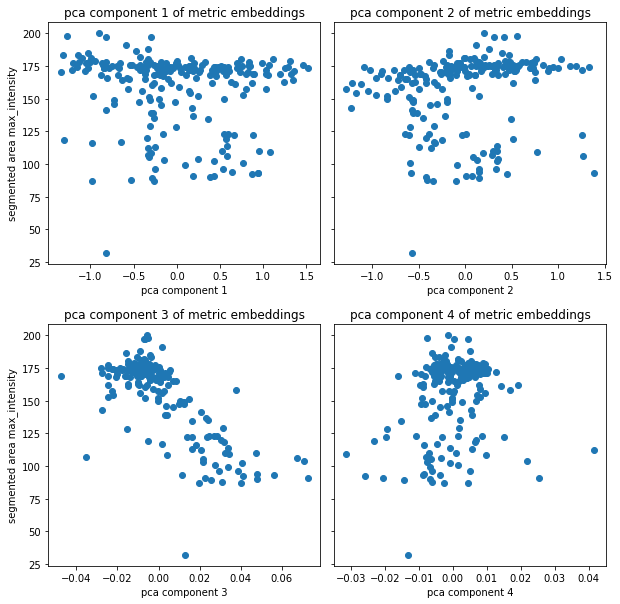

In [262]:
_ = plot_mean_pca_emb_vs_feature('max_intensity')

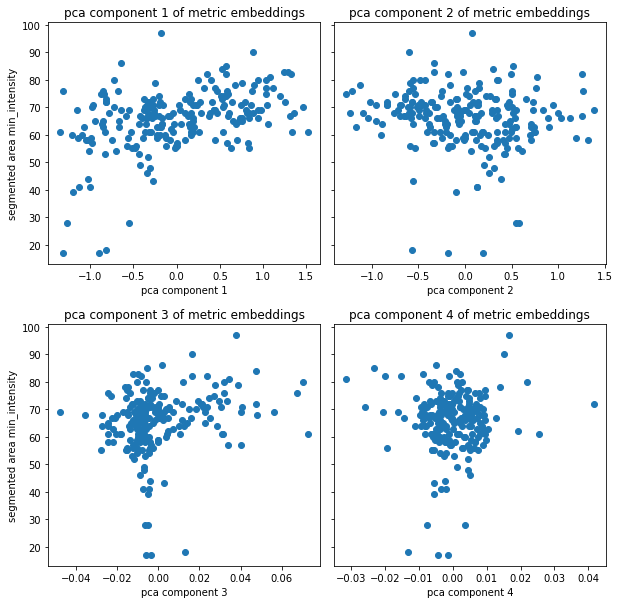

In [263]:
_ = plot_mean_pca_emb_vs_feature('min_intensity')

# plot training curves

In [306]:
import pandas as pd

In [309]:
df_aux_loss = pd.read_csv('/home/funkl/Downloads/run-version_48-tag-val_loss.csv')
df_naive_loss = pd.read_csv('/home/funkl/Downloads/run-version_51_val_performance_cremi-score-tag-val_performance.csv')
df_aux_cremi = pd.read_csv('/home/funkl/Downloads/run-version_48_val_performance_cremi-score-tag-val_performance.csv')
df_naive_cremi = pd.read_csv('/home/funkl/Downloads/run-version_51_val_performance_cremi-score-tag-val_performance.csv')

In [311]:
df_aux_loss

Wall time   Step     Value
0    1.633402e+09     74  0.833565
1    1.633402e+09    149  0.794106
2    1.633402e+09    224  0.728550
3    1.633402e+09    299  0.710660
4    1.633402e+09    374  0.761115
..            ...    ...       ...
995  1.633420e+09  74699  0.300141
996  1.633420e+09  74774  0.292348
997  1.633420e+09  74849  0.318596
998  1.633420e+09  74924  0.322935
999  1.633420e+09  74999  0.299423

[1000 rows x 3 columns]

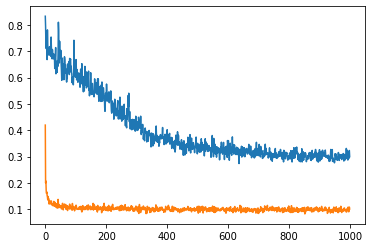

In [314]:
fig,ax = plt.subplots(1,1)
ax.plot(df_aux_loss['Value'])
ax.plot(df_naive_loss['Value']/4)

In [333]:
trained_model.offsets

[[-1, 0], [0, -1], [-9, 0], [0, -9]]

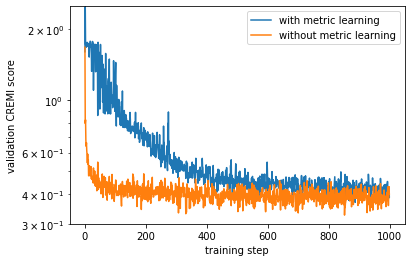

In [330]:
fig,ax = plt.subplots(1,1)
ax.plot(df_aux_cremi['Value'],label='with metric learning')
ax.plot(df_naive_cremi['Value'],label='without metric learning')
ax.set_ylim([0.3,2.5])
ax.set_yscale('log')
ax.set_xlabel('training step')
ax.set_ylabel('validation CREMI score')
ax.legend()
plt.savefig('experiments/training_curves.png',dpi=300,bbox_inches='tight',transparent=True)